# **CS 6120: Natural Language Processing - Prof. Ahmad Uzair** 

### **Assignment 3: n-gram Language Models, Word Sense disambiguation(LSA using SVD), LSTM**

### **Total points: 100**


# Q1. Latent Semantic Analysis (35 Points) 


 - A. Singular Value Decomposition (SVD) based distributed representation of text and documents. You can use python libraries for matrix decomposition (scipy). To demonstrate your work, use the example dataset (Table 2) of "R. A. Harshman (1990). Indexing by latent semantic analysis. Journal of the American society for information science". (10 Points)

 - B. Visualize (2-D) the documents and terms using library of your choice. (10 Points)

 - C. Implement a function that converts a query string to distributed representation and retrieves relevent documents. Visualize the the results as shown in Fig 1 of the paper. (10 Points)

## <CENTER>Task-1 (10 Points)

### Input data

In [91]:
#Dataset
c1 = 'Human machine interface for Lab ABC computer applications'
c2 = 'A survey of user opinion of computer system response time'
c3 = 'The EPS user interface management system'
c4 = 'System and human system engineering testing of EPS'
c5 = 'Relation of user-perceived response time to error measurement'
m1 = 'The generation of random, binary, unordered trees'
m2 = 'The intersection graph of paths in trees'
m3 = 'Graph minors IV: Widths of trees and well-quasi-ordering'
m4 = 'Graph minors: A survey'
documents = [c1, c2, c3, c4, c5, m1, m2, m3, m4]

### Perform preprocessing of documents

In the below cell remove punctuations and keep only words which belong to nltk corpus

In [1]:
# TASK CELL
import re
from nltk.tokenize import word_tokenize

def preprocess(message):
    '''
    Input:
        message: a string containing a message.
    Output:
        preprocessed_message_list: a list of words containing the processed message. 

    '''
    preprocessed_message_list, temp = list(), list()
    temp += word_tokenize(re.sub(r'[^\w\s]',' ',message))
    preprocessed_message_list += [word if word.isupper() and len(word)>1 else word.lower() for word in temp]

    return preprocessed_message_list

### Verify preprocessed data

In [93]:
for sent in documents:
    print(preprocess(sent))

['human', 'machine', 'interface', 'for', 'lab', 'ABC', 'computer', 'applications']
['a', 'survey', 'of', 'user', 'opinion', 'of', 'computer', 'system', 'response', 'time']
['the', 'EPS', 'user', 'interface', 'management', 'system']
['system', 'and', 'human', 'system', 'engineering', 'testing', 'of', 'EPS']
['relation', 'of', 'user', 'perceived', 'response', 'time', 'to', 'error', 'measurement']
['the', 'generation', 'of', 'random', 'binary', 'unordered', 'trees']
['the', 'intersection', 'graph', 'of', 'paths', 'in', 'trees']
['graph', 'minors', 'IV', 'widths', 'of', 'trees', 'and', 'well', 'quasi', 'ordering']
['graph', 'minors', 'a', 'survey']


##### Expected Output
```CPP
['human', 'machine', 'interface', 'for', 'lab', 'ABC', 'computer', 'applications']
['a', 'survey', 'of', 'user', 'opinion', 'of', 'computer', 'system', 'response', 'time']
['the', 'EPS', 'user', 'interface', 'management', 'system']
['system', 'and', 'human', 'system', 'engineering', 'testing', 'of', 'EPS']
['relation', 'of', 'user', 'perceived', 'response', 'time', 'to', 'error', 'measurement']
['the', 'generation', 'of', 'random', 'binary', 'unordered', 'trees']
['the', 'intersection', 'graph', 'of', 'paths', 'in', 'trees']
['graph', 'minors', 'IV', 'Widths', 'of', 'trees', 'and', 'well', 'quasi', 'ordering']
['graph', 'minors', 'a', 'survey']
```

### Assign names to document names
In the below cell create a list of document names. It will be later used to visualize documents

In [94]:
def createDocName(documents):
    '''
    Input:
        documents: list of documents.
    Output:
        doc_names: a list of document names. 
    '''

    names = list()
    doc_names = globals()
    for doc in documents:
        temp = [doc_name for doc_name in doc_names if doc_names[doc_name] is doc][0]
        names.append(temp)
    return names

In [95]:
docName = createDocName(documents)
print(docName)

['c1', 'c2', 'c3', 'c4', 'c5', 'm1', 'm2', 'm3', 'm4']


##### Expected Output
``` CPP
['c1', 'c2', 'c3', 'c4', 'c5', 'm1', 'm2', 'm3', 'm4']
```

### Words to Index mapping
Retrieve words from documents and create map of word and associate index to it

In [96]:
from nltk.corpus import words
corpus_words = words.words()

def build_word_to_ix(documents, stopwords=None):
    '''
    Input:
        documents: list of documents
        stopwords: list of stopwords
    Output:
        doc_names: map of words and assoicated index. 

    '''

    word_to_ix, temp_dict = dict(), dict()

    for line in documents:
        preprocessed_message_list = preprocess(line)
        for word in preprocessed_message_list:
            if word not in temp_dict:
                temp_dict[word] = 0
            temp_dict[word] += 1
            
    for key in temp_dict:
        if temp_dict[key] > 1:
            if key not in stopwords and key not in word_to_ix:
                word_to_ix[key] = len(word_to_ix)

    return word_to_ix

In [97]:
from nltk.corpus import stopwords

word_to_ix = build_word_to_ix(documents, stopwords.words('english'))
print(word_to_ix)

{'human': 0, 'interface': 1, 'computer': 2, 'survey': 3, 'user': 4, 'system': 5, 'response': 6, 'time': 7, 'EPS': 8, 'trees': 9, 'graph': 10, 'minors': 11}


##### Expected Output
```CPP
{'human': 0, 'interface': 1, 'computer': 2, 'user': 3, 'survey': 4, 'system': 5, 'time': 6, 'response': 7, 'EPS': 8, 'trees': 9, 'graph': 10, 'minors': 11}
```

### Document-Terms count matrix

In [98]:
from collections import Counter
import numpy as np

def build_td_matrix(documents, word_to_ix):
    '''
    Input:
        documents: list of documents.
        word_to_ix: {word, index} map
    Output:
        td_matrix: matrix of count of words in documents, each row 
            represent a word and each column represent a document

    '''
    td_matrix = np.zeros((len(word_to_ix), len(documents)))
    
    for col, docs in enumerate(documents):
        preprocessed_message_list = preprocess(docs)
        count = Counter(preprocessed_message_list)
        for word in word_to_ix:
            i = word_to_ix[word]
            td_matrix[i, col] = count[word]

    return td_matrix

In [99]:
X = build_td_matrix(documents, word_to_ix)
print(X)

[[1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 2. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]]


##### Expected Output
```CPP
[[1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 2. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]]
 ```

### Singular Value Decomposition
Perform singular value decomposition of count matrix into term singular vector matrix, singular value matrix and document singular vector matrix
- To perform the singular value decompostion please check tutorial:
https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html

In [100]:
import numpy as np

def svd(documents, word_to_ix, rank):
    '''
    Input:
        documents: list of documents.
        word_to_ix: {word, index} map
        rank: number of colums/rows to retain in decomposed matrix
    Output:
        Uk: term singular vector matrix
        Sk: singular value matrix
        Vk_t: transpose of document singular vector matrix
    '''
    td_matrix = build_td_matrix(documents, word_to_ix)
    Uk, S, Vk_t = np.linalg.svd(td_matrix)
    Sk = np.zeros((len(Uk), len(Vk_t)))
    Sk[:len(Vk_t),:len(Vk_t)] = np.diag(S)
    return Uk[:,:rank], Sk[:rank,:rank], Vk_t.T[:,:rank]

In [101]:
Uk, Sk, Vk_t = svd(documents, word_to_ix, 2)
print(Uk)
print(Sk)
print(Vk_t)

[[-0.22135078 -0.11317962]
 [-0.1976454  -0.07208778]
 [-0.24047023  0.04315195]
 [-0.20591786  0.27364743]
 [-0.40359886  0.05707026]
 [-0.64448115 -0.16730121]
 [-0.26503747  0.10715957]
 [-0.26503747  0.10715957]
 [-0.30082816 -0.14127047]
 [-0.01274618  0.49016179]
 [-0.03613585  0.62278523]
 [-0.03175633  0.45050892]]
[[3.34088375 0.        ]
 [0.         2.541701  ]]
[[-0.1973928  -0.05591352]
 [-0.60599027  0.16559288]
 [-0.46291751 -0.12731206]
 [-0.54211442 -0.23175523]
 [-0.27946911  0.10677472]
 [-0.00381521  0.19284794]
 [-0.01463147  0.43787488]
 [-0.02413684  0.6151219 ]
 [-0.08195737  0.52993707]]


##### Expected Output
```CPP 
[[-0.22135078 -0.11317962]
 [-0.1976454  -0.07208778]
 [-0.24047023  0.04315195]
 [-0.40359886  0.05707026]
 [-0.20591786  0.27364743]
 [-0.64448115 -0.16730121]
 [-0.26503747  0.10715957]
 [-0.26503747  0.10715957]
 [-0.30082816 -0.14127047]
 [-0.01274618  0.49016179]
 [-0.03613585  0.62278523]
 [-0.03175633  0.45050892]]
[[3.34088375 0.        ]
 [0.         2.541701  ]]
[[-0.1973928  -0.05591352]
 [-0.60599027  0.16559288]
 [-0.46291751 -0.12731206]
 [-0.54211442 -0.23175523]
 [-0.27946911  0.10677472]
 [-0.00381521  0.19284794]
 [-0.01463147  0.43787488]
 [-0.02413684  0.6151219 ]
 [-0.08195737  0.52993707]]
 ```

## <CENTER>Task-2 (10 Points)

### Visualize documents in 2D space

In [102]:
#Visualize documents and print coordinates
matrix1 = np.dot(Vk_t,Sk)
matrix1

array([[-0.65946641, -0.14211544],
       [-2.02454304,  0.42088758],
       [-1.54655358, -0.32358919],
       [-1.81114125, -0.5890525 ],
       [-0.9336738 ,  0.2713894 ],
       [-0.01274618,  0.49016179],
       [-0.04888203,  1.11294703],
       [-0.08063836,  1.56345595],
       [-0.27381004,  1.34694158]])

In [103]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=10).fit(matrix1)
labels = kmeans.labels_

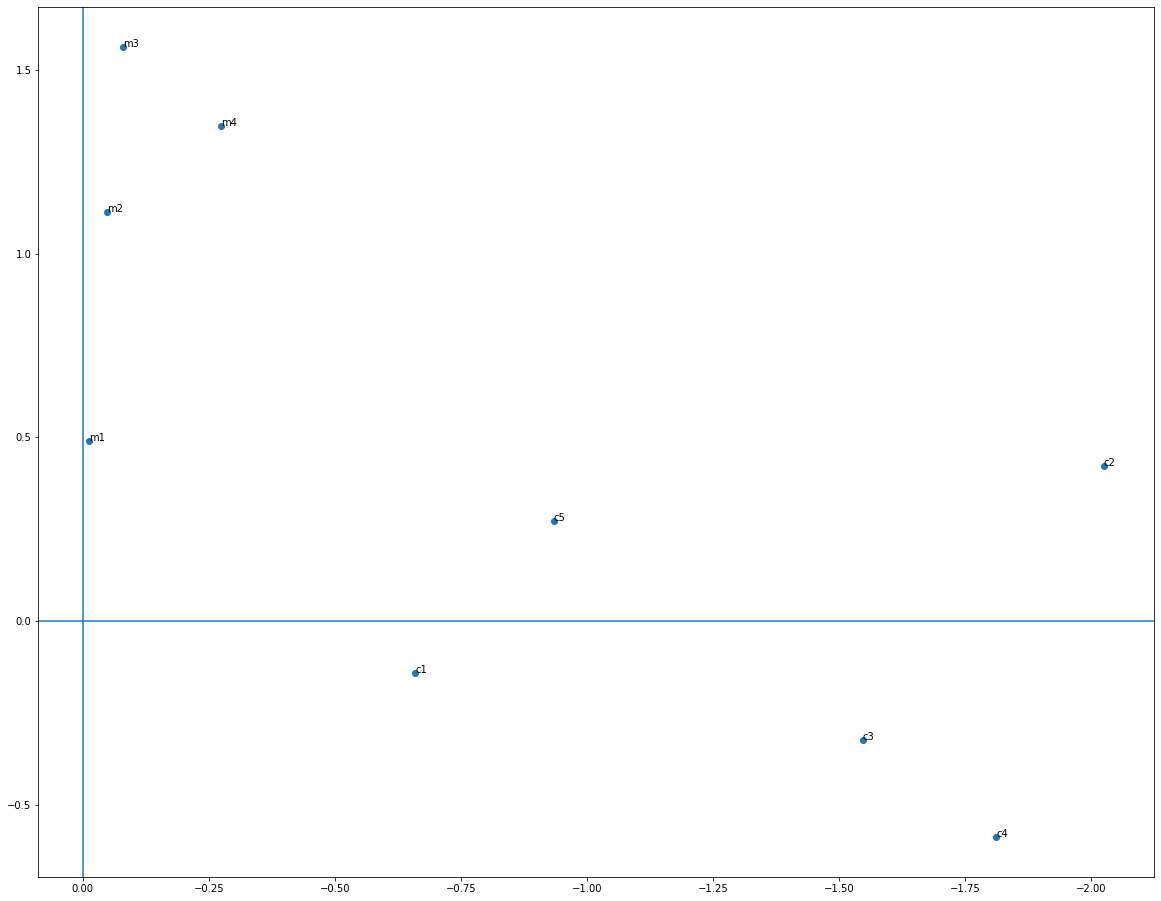

In [104]:
import matplotlib.pylab as plt

fig,ax = plt.subplots(figsize=(20,16))
ax.invert_xaxis()
xs, ys = matrix1[:, 0], matrix1[:, 1]
plt.scatter(xs, ys)

plt.axvline(x=0.0)
plt.axhline(y=0.0)

for x, y, name in zip(xs, ys, docName):
    plt.annotate(name, (x, y))

plt.show()

### Visualize terms in 2D space

In [105]:
#Visualize terms and print coordinates
matrix2 = np.dot(Uk,Sk)
matrix2

array([[-0.73950722, -0.28766875],
       [-0.66031031, -0.18322558],
       [-0.80338307,  0.10967936],
       [-0.68794764,  0.69552995],
       [-1.34837689,  0.14505553],
       [-2.15313661, -0.42522964],
       [-0.88545938,  0.27236759],
       [-0.88545938,  0.27236759],
       [-1.00503193, -0.35906729],
       [-0.04258352,  1.24584472],
       [-0.12072567,  1.58293385],
       [-0.1060942 ,  1.14505897]])

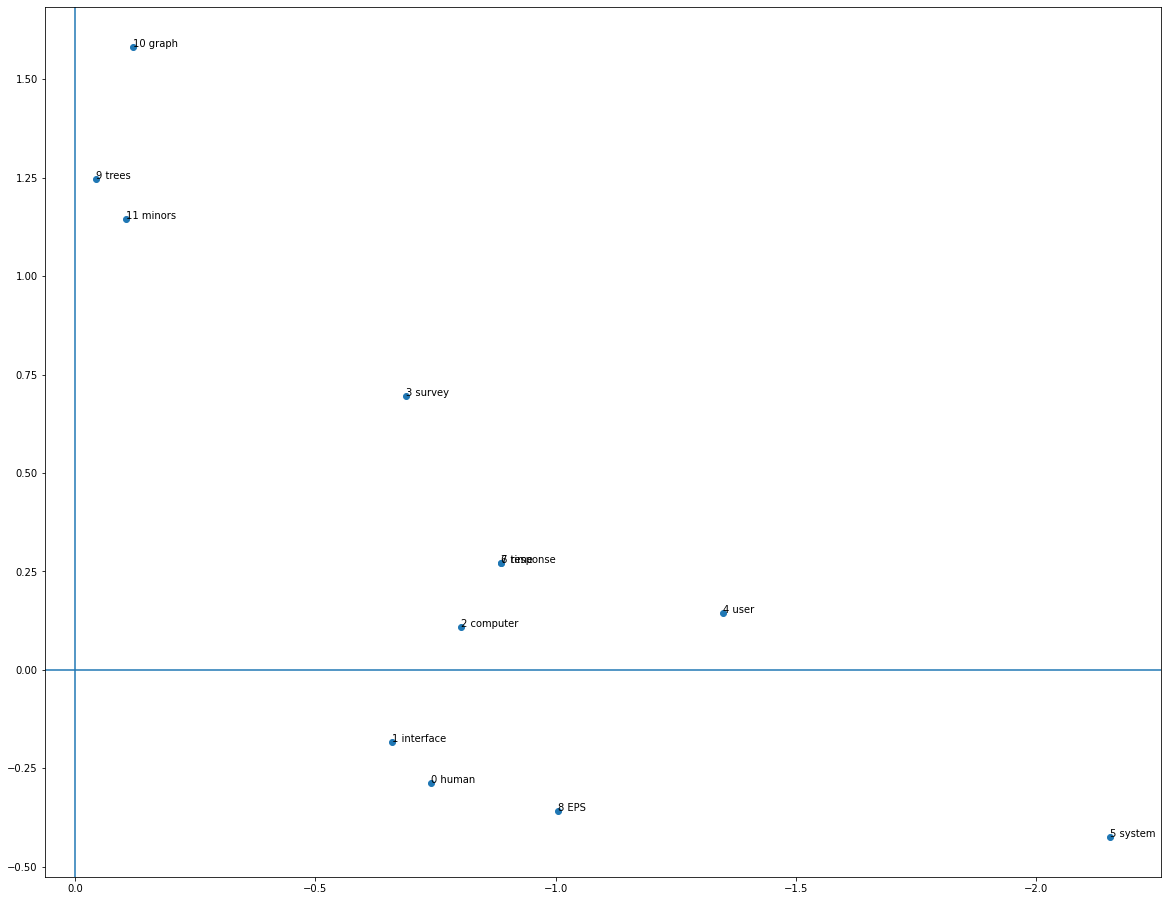

In [106]:
import matplotlib.pylab as plt

fig,ax = plt.subplots(figsize=(20,16))
ax.invert_xaxis()
xs, ys = matrix2[:, 0], matrix2[:, 1]
plt.scatter(xs, ys)
np.arange(0,10,1)

plt.axvline(x=0.0)
plt.axhline(y=0.0)

for x, y, name, i in zip(xs, ys, word_to_ix.keys(), range(len(word_to_ix))):
    plt.annotate(str(i) +' '+ name, (x, y))

plt.show()

## <CENTER>Task-3 (10 Points)

### Find matching documents for given document

In [107]:
# Hint create query vector for input document. Calculate its cosine distance from other documents


def query(s, Uk, Sk, Vk_t, word_to_ix, documents, min_score=0.9):
    '''
    Input:
        s:query document.
        Uk:Term matrix
        Sk:singular value matrix
        Vk_t:Document matrix
        word_to_ix: {word, index} map
        documents:list of document
        min_score:min score beyond which documents are considerd matching
    Output:
        q_hat: coordinates of query vector
        matches: list of tuples containing matching document and its score
    '''
    matches = list()
    q_hat = np.zeros(len(word_to_ix))

    for word in preprocess(s):
        if word in word_to_ix.keys():
            q_hat[word_to_ix[word]] += 1

    q_hat = np.dot(np.dot(q_hat, Uk), np.linalg.inv(Sk))

    for i, (x, y) in enumerate(Vk_t):
        q = q_hat[0] * x + q_hat[1] * y
        w = np.sqrt(np.square(q_hat[0]) + np.square(q_hat[1]))
        e = np.sqrt(np.square(x) + np.square(y)) 
        if q / (w * e) >= min_score:
            matches.append((documents[i], q / (w * e)))
            
    return q_hat, matches

In [108]:
q_hat, matches = query('human computer interaction', Uk, Sk, Vk_t, word_to_ix, documents, 0.9)
print(q_hat)
if matches is not None:
    print(matches)
else:
    print("No matches found")

[-0.13823319 -0.0275515 ]
[('Human machine interface for Lab ABC computer applications', 0.9968577502889867), ('The EPS user interface management system', 0.9974340858920454), ('System and human system engineering testing of EPS', 0.9785995267136451)]


##### Expected
```CPP
[-0.461821   -0.07002767]
[('The EPS user interface management system', 0.9984452813340272), ('Human machine interface for Lab ABC computer applications', 0.9980930095689974), ('System and human system engineering testing of EPS', 0.9865886405556598), ('A survey of user opinion of computer system response time', 0.9374863669686595), ('Relation of user-perceived response time to error measurement', 0.9075594362644345)]
```

### Visual representation of query/document

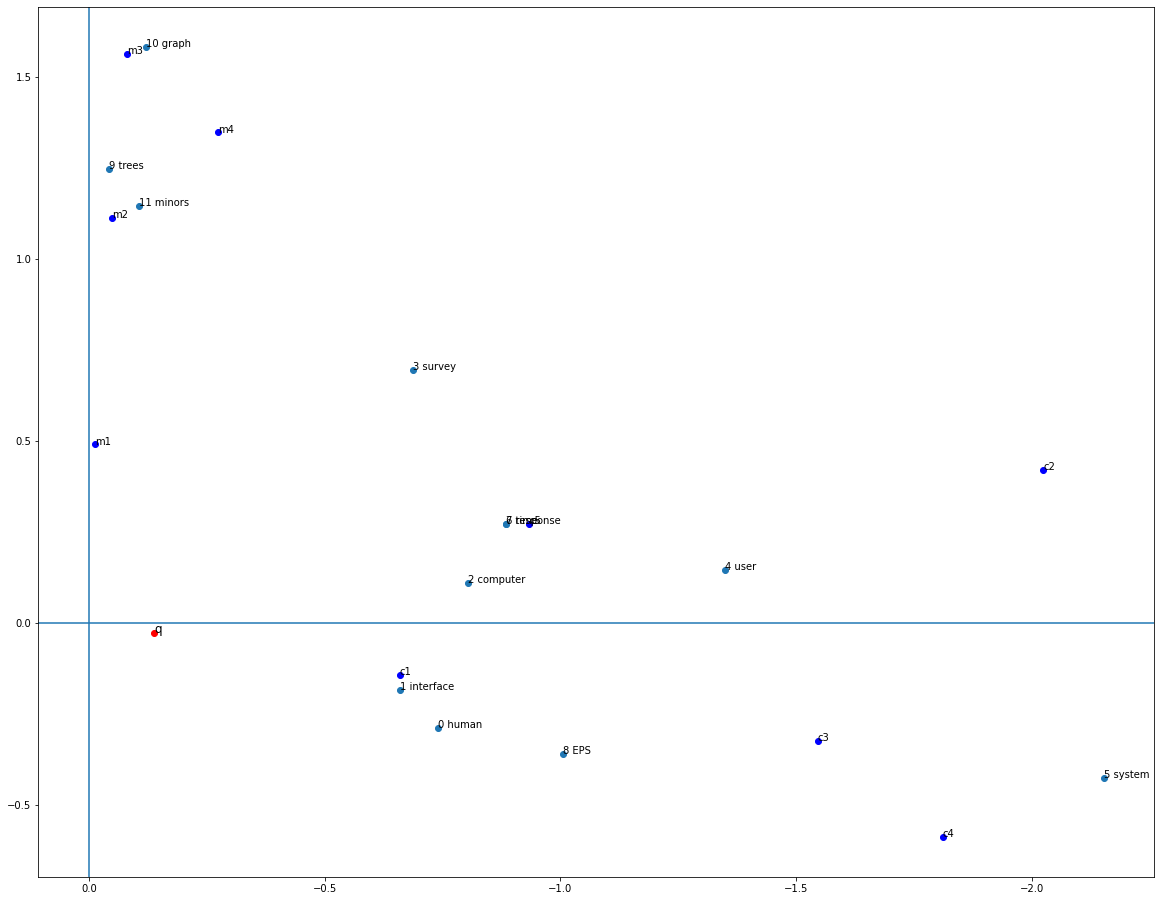

In [109]:
# Plot terms, documents and query documents along with lines representing its cosine angle 
import matplotlib.pylab as plt

fig,ax = plt.subplots(figsize=(20,16))
ax.invert_xaxis()

x1, y1 = matrix1[:, 0], matrix1[:, 1]
plt.scatter(x1, y1, c='b')
x2, y2 = matrix2[:, 0], matrix2[:, 1]
plt.scatter(x2, y2)
np.arange(0,10,1)

plt.scatter(q_hat[0], q_hat[1], c='r')
ax.text(q_hat[0], q_hat[1], 'q', fontsize=12)

plt.axvline(x=0.0)
plt.axhline(y=0.0)

for x, y, name in zip(x1, y1, docName):
    plt.annotate(name, (x, y))

for x, y, name, i in zip(x2, y2, word_to_ix.keys(), range(len(word_to_ix))):
    plt.annotate(str(i) +' '+ name, (x, y))

plt.plot(matches[0][1])

plt.show()

## **Theory questions: (5 points)**
- A) Give short description of Left-eigen vectors, right-eigen vectors and eigen-values matrix retured by Singular Value Decompostion of document-terms count matrix.
- B) Visually represent the document "Graph and tree generation" in 2D space along with words and documents as given in previous question.

#### **Answer:**
A) Any rectangular matrix, for example $m\times n$ of terms and documents, A, can be decomposed into the product of three other matrices: $$M = Uk * Sk * Vk^T$$ such that $Uk$ and $Vk$ are the columns and $Sk$ is the diagonal. $Vk^T$ is the conjugate transpose of $Vk$. $Uk$ and $Vk$ are the matrices of left and right singular vectors and $Sk$ is the diagonal matrix of singular values.


# Q2. n-Gram Language Models

Your task is to train n-gram language models. [Ref SLP Chapter 3]

- Task 1: You will train unigram, bigram, and trigram models on given training files. Then you will score on given test files for unigram, bigram, and trigram. you will generate sentences from the trained model and compute perplexity.
- Task 2: You will create training data for n > 3. and Repeat the above task from training model.
<h6>Part-A = (55 Points) </h6>

In [110]:
'''
Your imports go here
You are encouraged to implement your own functions and not use from library.
'''
import sys
from collections import Counter
import numpy as np

In [111]:
# constants to define pseudo-word tokens
# access via UNK, for instance
# for this assignemnt we will follow <s> tag for beginning of sentence and
# </s> for end of senetence as suggested in SLP Book. Check sample training files for reference.
UNK = "<UNK>"
SENT_BEGIN = "<s>"
SENT_END = "</s>"

We need to initialise global variables for model

In [112]:

"""Initializes Parameters:
  n_gram (int): the n-gram order.
  is_laplace_smoothing (bool): whether or not to use Laplace smoothing
  threshold: words with frequency  below threshold will be converted to token
"""
# Initializing different object attributes
n_gram = 3
is_laplace_smoothing = True
vocab = [] 
n_gram_counts = {}
n_minus_1_gram_counts = None
threshold = 1


### Implement training function (10 points)

In [113]:
def make_ngrams(tokens: list, n: int) -> list:
    """Creates n-grams for the given token sequence.
    Args:
    tokens (list): a list of tokens as strings
    n (int): the length of n-grams to create

    Returns:
    list: list of tuples of strings, each tuple being one of the individual n-grams
    """
    n_grams = []
    ## Your code here 
    for i in range(len(tokens) - (n-1)):
        n_grams.append(tuple(tokens[i:i+n]))
    return n_grams

In [114]:
def train(training_file_path):
    """Trains the language model on the given data. Input file that
    has tokens that are white-space separated, has one sentence per line, and
    that the sentences begin with <s> and end with </s>
    Parameters:
      training_file_path (str): the location of the training data to read

    Returns:
    N Gram Counts, Vocab, N Minus 1 Gram Counts
    """
    with open(training_file_path, 'r') as fh:
      content = fh.read().split() # Read and split data to get list of words
    
    # Get the count of each word
    count = dict()
    for word in content:
      if word not in count:
        count[word] = 0
      count[word] += 1
    
    # Replace the words with <UNK> if count is < threshold(=1)
    for word in count:
      if count[word] < threshold:
        count[UNK] = count.pop(word)

    # make use of make_n_grams function
    ngrams = make_ngrams(content, n_gram)
    for token in ngrams:
      if token not in n_gram_counts:
        n_gram_counts[token] = 0
      n_gram_counts[token] += 1

    # Get the training data vocabulary
    vocab = set(content)

    # For n>1 grams compute n-1 gram counts to compute probability
    if n_gram > 1:
      n_minus_1_gram_counts = dict()
      ngrams_minus_1 = make_ngrams(content, n_gram - 1)
      for token in ngrams_minus_1:
        if token not in n_minus_1_gram_counts:
          n_minus_1_gram_counts[token] = 0
        n_minus_1_gram_counts[token] += 1

    return n_gram_counts, vocab, n_minus_1_gram_counts

Output your Trained Data Parameters:

### Scoring function (points 5):
Implement Score function that will take input sentence and output probability of given string representing a single sentence.

In [115]:
n_gram_counts, vocab, n_minus_1_gram_counts = train("../input/dataset/berp-training-tri.txt")
print(n_gram_counts)
print(vocab)

{('<s>', '<s>', "let's"): 196, ('<s>', "let's", 'start'): 163, ("let's", 'start', 'over'): 136, ('start', 'over', '</s>'): 366, ('over', '</s>', '</s>'): 367, ('</s>', '</s>', '<s>'): 6755, ('</s>', '<s>', '<s>'): 6755, ('<s>', '<s>', 'my'): 6, ('<s>', 'my', 'mother'): 1, ('my', 'mother', 'is'): 1, ('mother', 'is', 'coming'): 1, ('is', 'coming', 'to'): 1, ('coming', 'to', 'visit'): 1, ('to', 'visit', 'and'): 1, ('visit', 'and', "i'd"): 1, ('and', "i'd", 'like'): 5, ("i'd", 'like', 'to'): 409, ('like', 'to', 'take'): 8, ('to', 'take', 'her'): 1, ('take', 'her', 'to'): 1, ('her', 'to', 'dinner'): 1, ('to', 'dinner', '</s>'): 7, ('dinner', '</s>', '</s>'): 224, ('<s>', '<s>', 'new'): 1, ('<s>', 'new', 'query'): 1, ('new', 'query', '</s>'): 1, ('query', '</s>', '</s>'): 2, ('<s>', '<s>', 'now'): 7, ('<s>', 'now', "i'm"): 3, ('now', "i'm", 'interested'): 6, ("i'm", 'interested', 'in'): 33, ('interested', 'in', 'some'): 2, ('in', 'some', 'middle'): 1, ('some', 'middle', 'eastern'): 5, ('midd

In [116]:
def score(sentence):
    """Calculates the probability score for a given string representing a single sentence.
    Parameters:
      sentence (str): a sentence with tokens separated by whitespace to calculate the score of
      
    Returns:
      float: the probability value of the given string for this model
    """
    # Split the input sentence and replace out of vocabulary tokens with <UNK> 
    content = sentence.split()
    tokens = list()
    for word in content:
      if word not in vocab:
        tokens.append(UNK)
      else:
        tokens.append(word)

    # Calculate probability for each word and multiply(or take log and sum) them to get the sentence probability
    ngrams = make_ngrams(tokens, n_gram)
    ngrams_minus_1 = make_ngrams(tokens, n_gram - 1)

    ngrams_total = sum(n_gram_counts.values())
    ngrams_minus_1_total = sum(n_minus_1_gram_counts.values())

    probablity = 0

    for i in range(len(ngrams)):
      probablity += np.log((n_gram_counts.get(ngrams[i], 0) + 1) / (ngrams_total + len(vocab))) - np.log((n_minus_1_gram_counts.get(ngrams_minus_1[i], 0) + 1) / (ngrams_minus_1_total + len(vocab)))

    return probablity

In [117]:
with open("../input/dataset/hw2-test-tri.txt", 'r') as fh:
    test_content = fh.read().split("\n")
num_sentences_1 = len(test_content)
ten_sentences_1 = test_content[:10]
print("# of test sentences: ", num_sentences_1)
probablities = []

# of test sentences:  102


In [118]:
# print probabilities/score of sentences in test content
for sentence in test_content:
  probablities.append(score(sentence))
probablities = np.array(probablities)
mean = np.mean(probablities)
std_dev = np.std(probablities)

In [119]:
print(probablities)

[ -9.62919467  -9.08664378 -14.43860946 -10.26403105 -15.84579328
  -9.40635558 -11.89418833 -13.67019696 -14.51702791  -8.81829239
  -8.81827842  -9.9783271   -8.58901126  -6.27453127 -12.72893927
  -6.83462795  -7.43199803  -7.6337237  -12.32101726 -11.95729738
 -24.72462736 -18.75078274 -17.5781891  -15.99296055 -11.98249451
 -11.2846587   -7.15850146 -10.04885925 -15.69625298 -14.12313717
  -9.92045055 -19.64853378 -11.42118572 -13.51564497 -15.85570058
 -15.04749102  -8.25910777  -8.41091076 -11.36592056 -10.35326334
 -12.12451791 -11.05704468 -10.74928434 -13.57856054 -12.04615136
 -10.18135735  -9.04140801 -11.16963971 -12.92269157 -15.74217472
 -12.40171357 -12.19596036  -5.4906129   -4.03613369  -4.03613369
 -12.5023427  -12.64922474  -8.12514521  -6.33557972 -16.0424991
  -3.44206078 -11.9106039  -17.440516    -8.41278538 -18.46283213
 -13.55822026  -8.81827842  -6.73885085  -8.12514521 -18.57026706
 -17.83387865 -15.47998286  -9.28665649  -9.17492544 -17.58147983
  -8.818264

In [120]:
print(mean)

-11.469666732601626


In [121]:
print(std_dev)

4.321823117892292


### Sentence generation (10 points)
Generate sentence from the above trained model
- To generate next word from a set of probable n-grams and their probabilities check below tutorial:
https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

In [122]:
import random

def generate_sentence():
    """Generates a single sentence from a trained language model using the Shannon technique.
      
    Returns:
      str: the generated sentence
    """
    # Start with <s> and randomly generate words until we encounter sentence end
    prev_word = '<s>'
    sentence = list()
    sentence.append('<s>')
    # Append sentence begin markers for n>2
    # Keep track of previous word for stop condition
    if n_gram > 1:
      if n_gram > 2:
        temp = ['<s>' for i in range(n_gram - 2)]
        sentence += temp
      prev = ['<s>' for i in range(n_gram - 1)]
      while prev_word != "</s>":
        # Construct the (n-1) gram so far
        # Get the counts of all available choices based on n-1 gram
        # Convert the counts into probability for random.choice() function
        # If <s> is generated, ignore and generate another word
        tokens, tokens_occur = list(), list()
        for count in n_gram_counts:
          if list(count[:n_gram - 1]) == prev:
            tokens.append(count)
            tokens_occur.append(n_gram_counts[count])
        convert_counts = random.choices(tokens, tokens_occur, k=1)[0]
        word = convert_counts[-1]

        if word != '<s>':
          sentence.append(word)
          prev_word = word
          prev = prev[1:]
          prev.append(word)

    else:
      # In case of unigram model, n-1 gram is just the previous word and possible choice is whole vocabulary
      while prev_word != "</s>":
        # Convert the counts into probability for random.choice() function
        # If <s> is generated, ignore and generate another word
        word = random.choices(vocab)
        
        if word != '<s>':
          sentence.append(word)
          prev_word = word

    # Append sentence end markers for n>2
    if n_gram > 2:
        temp = ['</s>' for i in range(n_gram - 2)]
        sentence += temp
    
    return " ".join(sentence)

In [123]:
def generate(n):
    """Generates n sentences from a trained language model using the Shannon technique.
    Parameters:
      n (int): the number of sentences to generate
      
    Returns:
      list: a list containing strings, one per generated sentence
    """
    # Generate sentences one by one and store
    sentences = [generate_sentence() for i in range(n)]
    return sentences

In [124]:
sentences = generate(50)
print("Sentences:")
for sentence in sentences:
  print(sentence)

Sentences:
<s> <s> saturday night </s> </s>
<s> <s> does musical offering </s> </s>
<s> <s> i like to </s> </s>
<s> <s> i'd like to see the menu of the norteno's </s> </s>
<s> <s> what's the cheapest italian restaurant in berkeley </s> </s>
<s> <s> what else can you give me information about addison annex </s> </s>
<s> <s> not much </s> </s>
<s> <s> i'd like to eat pizza </s> </s>
<s> <s> it doesn't really matter </s> </s>
<s> <s> i want to go to some expensive restaurants </s> </s>
<s> <s> uh well i said i don't want to spend </s> </s>
<s> <s> what is the i-house cafe located </s> </s>
<s> <s> hi i'm looking for restaurants which have vegetarian dishes </s> </s>
<s> <s> tell me about fat slice pizza </s> </s>
<s> <s> okay i'd like to have lunch </s> </s>
<s> <s> doesn't matter to me </s> </s>
<s> <s> i would like to see the menu of hong-kong villa </s> </s>
<s> <s> i would like to spend more than five dollars </s> </s>
<s> <s> hi i would pay fifty dollars per person </s> </s>
<s> <s> 

### Evaluate model perplexity (5 points)
Measures the perplexity for the test sequence with your trained model. 
you may assume that this sequence may consist of many sentences "glued together"

The perplexity of the given sequence is the inverse probability of the test set, normalized by the number of words.


In [125]:
# Since this sequence will cross many sentence boundaries, we need to include 
# the begin- and end-sentence markers <s> and </s> in the probability computation. 
# We also need to include the end-of-sentence marker </s> 
# but not the beginning-of-sentence marker <s>) in the total count of word tokens N
import math
def perplexity(test_sequence):
    """.
    Parameters:
      test_sequence (string): a sequence of space-separated tokens to measure the perplexity of

    Returns:
      float: the perplexity of the given sequence
    """ 

    # Replace out of vocab words with <UNK>, already done in score function
    test_sequence = [token if token in vocab else UNK for token in test_sequence.split()]
    
    ngrams = make_ngrams(test_sequence, n_gram)
    ngrams_minus_1 = make_ngrams(test_sequence, n_gram - 1)

    ngrams_total = sum(n_gram_counts.values())
    ngrams_minus_1_total = sum(n_minus_1_gram_counts.values())

    probablity = 0

    for i in range(len(ngrams)):
      probablity += np.log((n_gram_counts.get(ngrams[i], 0) + 1) / (ngrams_total + len(vocab))) - np.log((n_minus_1_gram_counts.get(ngrams_minus_1[i], 0) + 1) / (ngrams_minus_1_total + len(vocab)))

    #probablity = probablity / len(ngrams)
    # Remove sentence begin markers from data for computing N
    # Get the probability for the sequence
    perplexity = math.exp(-1 * probablity / len(ngrams)) 
    #perplexity = np.power(2, -probablity)
    
    return perplexity

In [126]:
print(perplexity(" ".join(sentences[0:10])))

3.2174699488213916


### **Explore and explain: (5 points)**
* Experiment n_gram model for n = [1,2,3..7] of your choice. Explain the best choice of n that generates more meaninful sentences.


### Answer:

An n-gram is a sequence of n words, such as a 2-gram (also called bigram) is a two-word sequence of words like " please turn".

# Q3. Classification using LSTM - using Tensorflow (30 Points)
In this part, we will be building a bidirectional LSTM network to train and inference sentiment analysis on IMDB dataset.<br>

If you need a refresher or have never worked with Neural Networks before, here are a few resources:
- https://web.stanford.edu/~jurafsky/slp3/7.pdf
- https://web.stanford.edu/~jurafsky/slp3/9.pdf
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/


Training a neural network model will take time. 
- You can use Google Colab / Kaggle notebooks. You get a free GPU for a limited time to tweak your hyperparameters.
- Without a GPU, You might have to wait longer to experiment.

### Library Imports

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer



### Visualizing data distribution (1 Point)


In [3]:
## Reading the data and removing columns that are not important. 
dataset = pd.read_csv("../input/dataset/movie_reviews.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [4]:
#######################################################   
# print head of data frame with help of head function # 
#######################################################
 
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


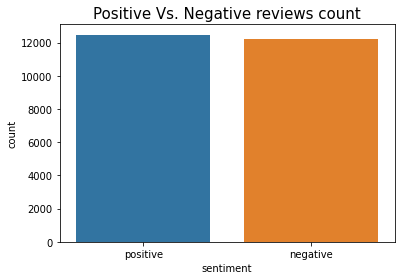

In [5]:
 ####################################################### 
 # plot Positive Vs. Negative reviews count            # 
 #######################################################

sns.countplot(dataset['sentiment'])

plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()


### Cleaning the Reviews (2 Points)

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import pandas as pd
import re
import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

# From the first assignment
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [7]:
#############################################################################################  
# Clean all the reviews in the dataset using the clean_text function provided above         # 
############################################################################################# 

cleaned_text = list()
for line in dataset['review']: 
    cleaned_text.append(clean_text(line))

In [8]:
#####################################################################
# print head of the "CLEANED" data frame with help of head function # 
#####################################################################


cleaned_text = pd.DataFrame(cleaned_text)
cleaned_text = pd.concat([cleaned_text, dataset['sentiment']], axis=1)
cleaned_text.columns = ['review','sentiment']

cleaned_text.head()

,review,sentiment
0,one reviewer mentioned watching 1 oz episode y...,positive
1,wonderful little production br br filming tech...,positive
2,thought wonderful way spend time hot summer we...,positive
3,petter matteis love time money visually stunni...,positive
4,probably alltime favorite movie story selfless...,positive


### Splitting the dataset and Encoding Labels (2 Points)

Spliting data: <br> 
80% for the training and the remaining 20% for validation.

Encoding Labels: <br>
Encode labels as negative and positive as 0 and 1 respectively


In [9]:
#################################################################################
# Split the data using the sklearn module                                       #
# 80% for the training and the remaining 20% for validation                     #
#################################################################################

x_train, x_test, y_train, y_test = train_test_split(cleaned_text['review'], cleaned_text['sentiment'], test_size=0.2)

In [10]:
#################################################################################
# Initialize label encoder from sklearn module                                  #
# fit on train labels and transform both train and validation labels            #
#################################################################################

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

### Pre-Processing The Text (5 Points)
 

In [11]:
# You can use the modules given below
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

###############################################################################  
# Fit your tokenizer on the training reviews                                  #
###############################################################################

tokenizer = Tokenizer(oov_token='<UNK>', num_words=None)
tokenizer.fit_on_texts(x_train)

#################################################################################################
# The word_index dictionary assigns a unique index to each unique word present in the training  #
# reviews.                                                                                      #
#                                                                                               #
# Create the word_index dictionary using the tokenizer                                          #
# Find the vocabulary of your training reviews                                                  #
#################################################################################################

word_index = tokenizer.index_word

vocabulary = [key for key, value in  tokenizer.word_counts.items() ]


#################################################################################################
# Convert the reviews in the dataset to their index form by using a function available          #
# with the tokenizer                                                                            #
# HINT : convert training and validation reviews into sequences                                 #
#################################################################################################

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)

#################################################################################################
# Pad the the training and validation sequences so all of them have the same length             # 
# set maxlen = 200                                                                              #
#################################################################################################

# maxlen which is the maximum length of one review we will use for our training
X_train = pad_sequences(X_train, maxlen=200, padding='post')
X_test = pad_sequences(X_test, maxlen=200, padding='post')

print('Vocabulary : {}'.format(vocabulary))

Vocabulary : ['like', 'tarzan', 'ape', 'man', '1932', 'there', 'everything', 'animal', 'varied', 'african', 'tribe', 'scene', 'thought', 'must', 'good', 'three', 'four', 'lion', 'forty', 'would', 'better', 'wrestle', 'crocodilesâ', 'crocodile', 'machine', 'spin', 'water', 'rolling', 'pin', 'around', 'jaw', 'flapping', 'kill', 'ubiquitous', 'knife', 'blasted', 'saurian', 'hold', 'still', 'rhino', 'steadily', 'increasing', 'number', 'friend', 'real', 'chimp', 'people', 'wearing', 'larger', 'costume', 'elephant', 'fact', 'use', 'indian', 'elephantsâ', 'far', 'friendly', 'trainable', 'onesâ', 'ear', 'attached', 'head', 'human', 'story', 'another', 'white', 'worse', 'rest', 'show', 'join', 'holt', 'go', 'ivory', 'graveyard', 'wont', 'way', 'bad', 'guy', 'shoot', 'follow', 'deathbed', 'intercedes', 'himâ', 'course', 'survives', 'return', 'save', 'jane', 'everybody', 'else', 'dy', 'every', 'single', 'one', 'boy', 'expendable', 'especially', 'doesnt', 'seem', 'much', 'distinction', 'black', 'f

### Using glove vectors for embedding (5 Points)

GloVe vectors capture both global statistics and local statistics of a corpus. We use GloVe to convert words to embeddings in the vector space based on their semantics. 

We will be using the 200-dimensional GloVe vectors for the task at hand.

To learn more about GloVe please read the following resource:
- https://nlp.stanford.edu/pubs/glove.pdf

In [12]:
glove_dictionary = {}
with open('../input/glove6b200d/glove.6B.200d.txt', encoding="utf8") as file:
    for each_line in file:
        words_in_line, coeff_cients = each_line.split(maxsplit=1)
        coeff_cients = np.array(coeff_cients.split(),dtype = float)
        glove_dictionary[words_in_line] = coeff_cients

In [13]:
 # All the words which are not in the GloVe dictionary will be assigned a zero vector.

embedding_matrix = np.zeros((len(word_index), 200))

######################################################################
# The glove_dictionary contains words vs their respective embeddings #
#                                                                    #
# Create the embedding matrix using the glove_dictionary             #
######################################################################

for word, index in word_index.items():
    embedding_vector = glove_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index, :] = embedding_vector


In [14]:
embedding_matrix.shape

(99920, 200)

Sample output : (99987, 200)

### Creating The Model (10)

If you need a refresher or have never worked with Neural Networks before, here are a few resources:
- https://web.stanford.edu/~jurafsky/slp3/7.pdf
- https://web.stanford.edu/~jurafsky/slp3/9.pdf
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/


Training a neural network model will take time. 
- You can use Google Colab / Kaggle notebooks. You get a free GPU for a limited time.
- Without a GPU, You might have to wait longer to experiment.


Useful resources : <br>
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential <br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense <br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout <br>





In [15]:
import tensorflow as tf
from keras.layers.embeddings import Embedding
from keras.layers import LSTM, Activation, Dropout, Dense, Input, Bidirectional
from keras.models import Model
from keras.initializers import Constant
import keras

tf.random.set_seed(42)

######################################################
# Complete this linear model in tensorflow           #
######################################################

def build_model(embedding_matrix):
    ''' 
      Arguments:
        embedding_matrix : a matrix with the corresponding embeddings
        of all words.

      Returns:
        The LSTM model that you created.
      '''
    
    model = tf.keras.Sequential()
  
  # TO DO: layer 1 : add embedding layer
  # The embedding layer maps the words to their embedding vectors from the embedding matrix
    
    embedding_layer = Embedding(input_dim=len(word_index), output_dim=200, weights=[embedding_matrix], input_length=200, trainable=True)
    model.add(embedding_layer)

  # TO DO: layer 2 : add Bidirectional LSTM Layer 
    
    model.add(Bidirectional(LSTM(100, return_sequences=True, dropout=0.2)))

  # TO DO Add more layers : you can add more dense layers and dropout
  # NOTE : You should be able to achieve an validation accuracy greater than 85%
  #        within 10 epochs

  # TO DO Final layer : add output layer and activation 
    
    model.add(Bidirectional(LSTM(100, dropout=0.2)))
    model.add(Dense(1, activation='sigmoid'))

  # TO DO : use a loss function, optimizer as adam to compile 
  # and evaluate model on auc,precision,recall,accuracy
  # HINT : choose your loss function based on the task (binary classification)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')])
    
    return model

In [16]:
# NOTE : You should be able to achieve an validation accuracy greater than 85%
#        within 10 epochs

#################################################################
# Call the build_model function and initialize the model        #
#################################################################

model = build_model(embedding_matrix)
result = model.fit(x=X_train, y=y_train, epochs=10, batch_size = 32, validation_data=(X_test, y_test))

#######################################################################################################
# train and validate the model on the padded sequences of text which we have created initially        #
#######################################################################################################


2022-07-09 17:53:24.490165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 17:53:24.658436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 17:53:24.659615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 17:53:24.662066: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/10


2022-07-09 17:53:37.535718: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


618/618 [==============================] - 45s 57ms/step - loss: 0.4405 - accuracy: 0.7995 - precision: 0.7861 - recall: 0.8303 - auc: 0.8766 - val_loss: 0.3661 - val_accuracy: 0.8455 - val_precision: 0.8558 - val_recall: 0.8297 - val_auc: 0.9185
Epoch 2/10
618/618 [==============================] - 34s 55ms/step - loss: 0.1846 - accuracy: 0.9350 - precision: 0.9341 - recall: 0.9379 - auc: 0.9771 - val_loss: 0.3457 - val_accuracy: 0.8623 - val_precision: 0.8970 - val_recall: 0.8175 - val_auc: 0.9343
Epoch 3/10
618/618 [==============================] - 35s 57ms/step - loss: 0.0992 - accuracy: 0.9673 - precision: 0.9666 - recall: 0.9689 - auc: 0.9923 - val_loss: 0.3891 - val_accuracy: 0.8470 - val_precision: 0.8339 - val_recall: 0.8650 - val_auc: 0.9198
Epoch 4/10
618/618 [==============================] - 35s 57ms/step - loss: 0.0457 - accuracy: 0.9864 - precision: 0.9868 - recall: 0.9863 - auc: 0.9975 - val_loss: 0.4973 - val_accuracy: 0.8460 - val_precision: 0.8562 - val_recall: 0.83

### Plotting Accuracy and Losses (5 Points)
 




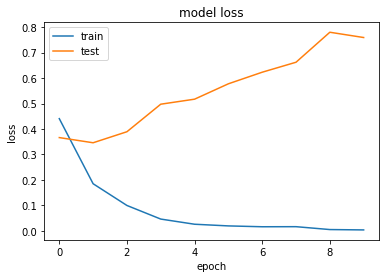

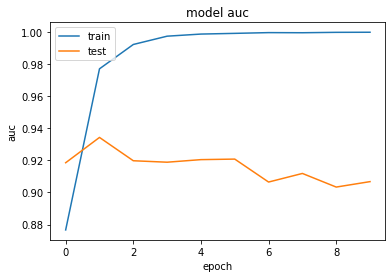

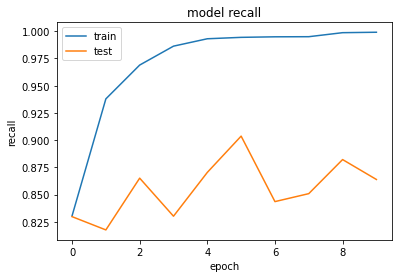

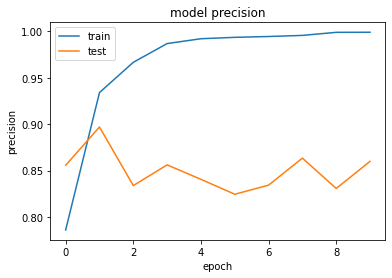

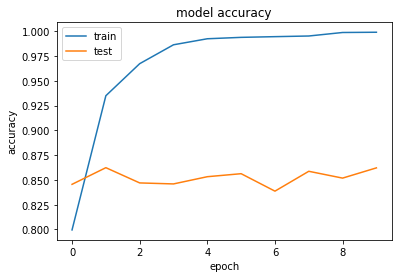

In [17]:
####################################
# PLOT :                           #
# train loss vs val loss           #
# train auc vs val auc             #
# train recall vs val recall       #
# train precision vs val precision #
# train accuracy vs val accuracy   #
####################################

from matplotlib import pyplot as plt

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(result.history['auc'])
plt.plot(result.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(result.history['recall'])
plt.plot(result.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(result.history['precision'])
plt.plot(result.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
# You will need to include the pickled model along with the other submission files
# The saved model will be used to verify your lstm's predictions on hidden reviews

##################################################################################
# Save your trained model as a pickle file named "lstm_classifier"               #
# You will be using this saved model to make predictions in the next module      #
##################################################################################

model.save("lstm_classifier.h5")

### Prediction (5 Points)

In [19]:
######################################################################
# Load your saved model                                              #
# Use the saved model to make predictions                            #
######################################################################
from keras.models import load_model
    
saved_model = load_model("./lstm_classifier.h5")

In [43]:
# use the saved model to predict the reviews
def predict_review(review):
    '''
      Arguments:
        review : A single review for which you want to predict the sentiment for.
                 example: "This movie was amazing! I would defenitely watch it again."

      Returns:
        The predicted sentiment for the review : either 1 or 0
      '''
    
    ############################################################################# 
    # Predict the sentiment for the given review using the model                #
    # that you trained and return the sentiment                                 #
    #                                                                           #
    # HINT : Remember that the review needs to be "preprocessed" before you use #
    # it for prediction                                                         #
    #############################################################################
    x = tokenizer.texts_to_sequences(preprocess(review))
    x = pad_sequences(x, maxlen=200, padding='post')

    x = saved_model.predict(x)
    
    prediction = np.transpose(x)[0]
    prediction = list(map(lambda x: 0 if x < 0.5 else 1, prediction))
    
    predictions = 1
    for pred in prediction:
        if pred != 1:
            predictions = 0
            return predictions
    return predictions





In [44]:
# Do not edit this cell

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = predict_review(review)
    print(f'{review[:100]} -> {p}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 1
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 0
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 1
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 0


### Expected Output:

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 1 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 0 <br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 1 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 0